In [68]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result


In [69]:
from pathlib import Path
comp_dir = Path("D:\Python(New)\Project\Credit_Card_Fraud_Detection\data")
pd.set_option('display.max_columns', None)
credit_card = pd.read_csv(comp_dir / "creditcard.csv")

## Data Basic Information

In [70]:
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [71]:
# Check card info
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [72]:
# basic statistics
credit_card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking to the `Time` feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

In [73]:
# Check shape
print('Credit Card Fraud Detection data - rows:', credit_card.shape[0], 'columns:', credit_card.shape[1])

Credit Card Fraud Detection data - rows: 284807 columns: 31


## Data Quality Check

### Null Value Check

In [74]:
# Check for null/missing values
total = credit_card.isnull().sum().sort_values(ascending = False)
percent = (credit_card.isnull().sum()/credit_card.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

### Data Unbalance

Check data unbalance with respect with target value, `Class`

In [75]:
temp = credit_card['Class'].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

In [76]:
trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not Fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class (Not Fraud = 0, Fraud = 1)',
            xaxis = dict(title = 'Class', showticklabels=True),
            yaxis = dict(title = 'Number of Transactions'),
            hovermode = 'closest',width=600
                )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

From the above graph, Out of all transactions, only 492 (0.172%) are fraudulent. This indicates that the data is severely imbalanced in regards to the target variable `Class`.

## Data Exploration

### Transaction in time

In [77]:
class_0 = credit_card.loc[credit_card['Class']==0]['Time']
class_1 = credit_card.loc[credit_card['Class']==1]['Time']

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions are evenly distributed in time, including during low real transaction times, such as at night in the European timezone. This distribution is more uniform than that of valid transactions.

To further analyze this, we will examine the time distribution of both types of transactions, as well as the total transaction count and amount per hour. It is assumed that the time unit is second, based on observations of the transaction time distribution.

In [78]:
credit_card['Hour'] = credit_card['Time'].apply(lambda x: np.floor( x/3600))
credit_card['Hour']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
284802    47.0
284803    47.0
284804    47.0
284805    47.0
284806    47.0
Name: Hour, Length: 284807, dtype: float64

In [79]:
tmp = credit_card.groupby(['Hour','Class'])['Amount'].aggregate(['min','max','count','sum','mean','median','var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour','Class','Min','Max','Transactions','Sum','Mean','Median','Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


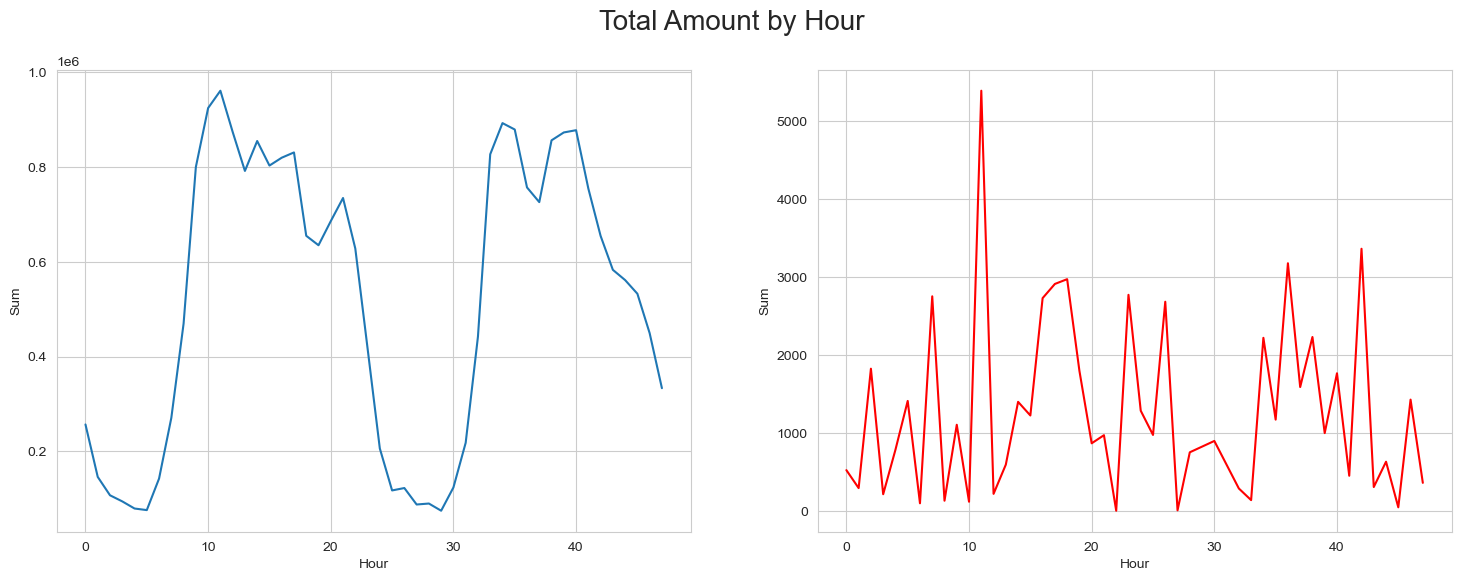

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
line_graph = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
line_graph = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount by Hour", fontsize=20)
plt.show()

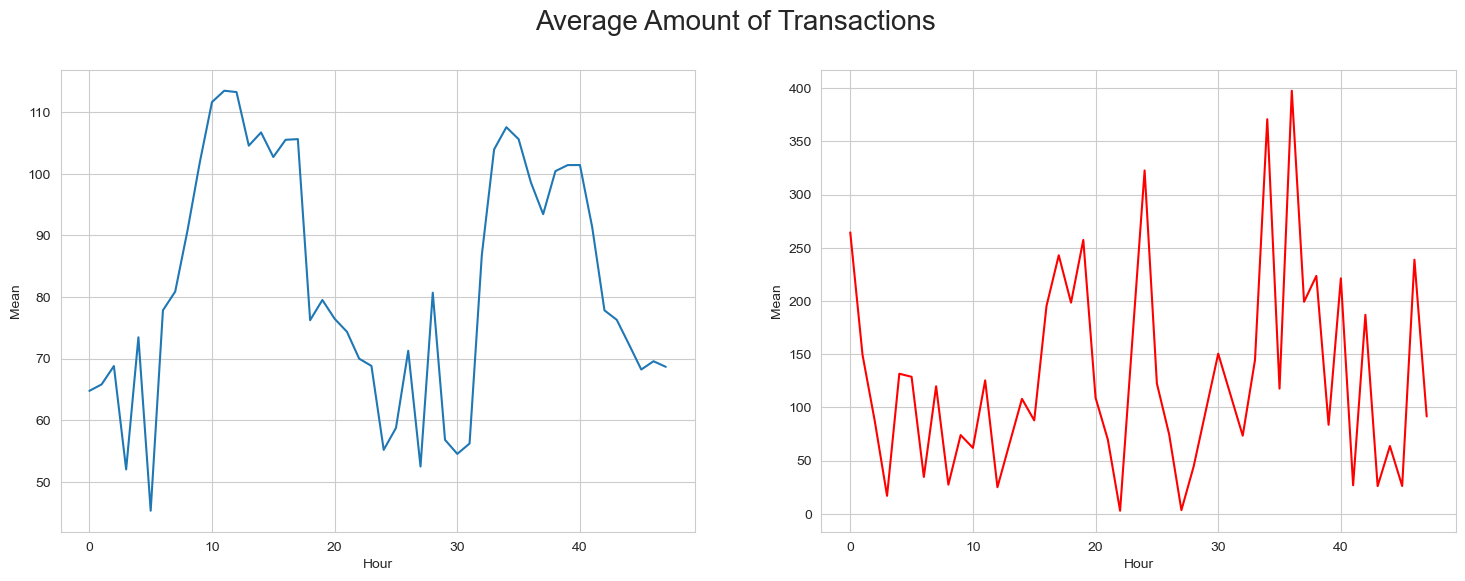

In [81]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions", fontsize=20)
plt.show()

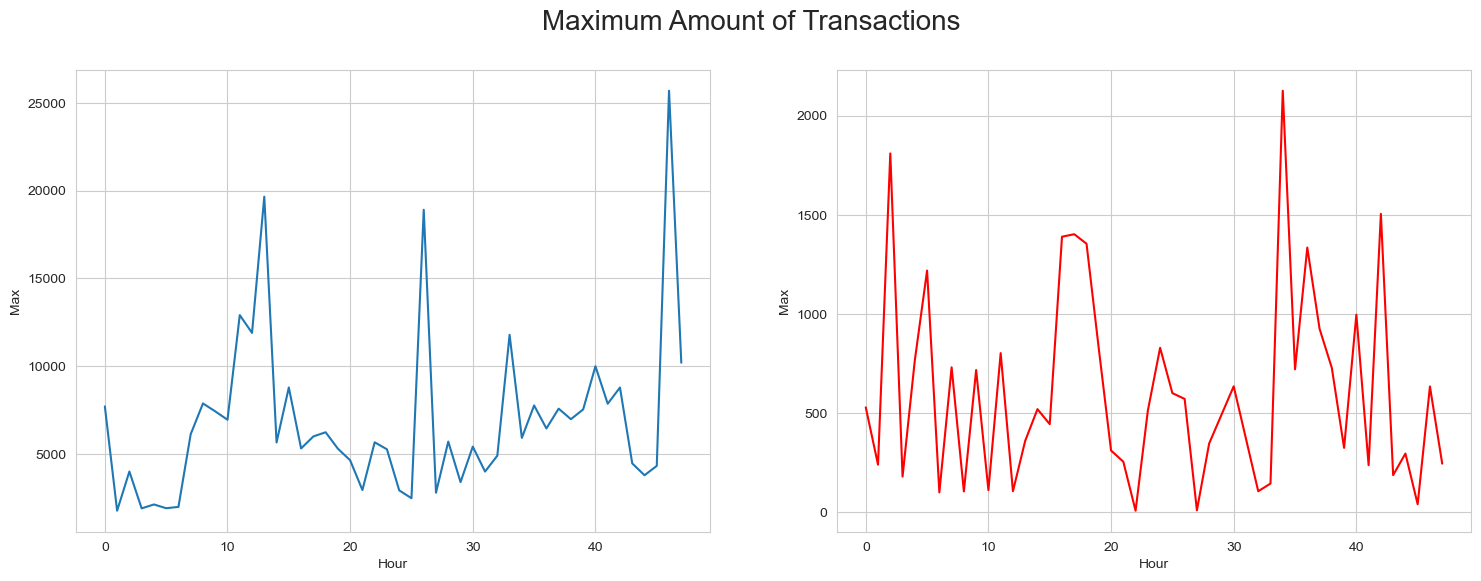

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions", fontsize=20)
plt.show()

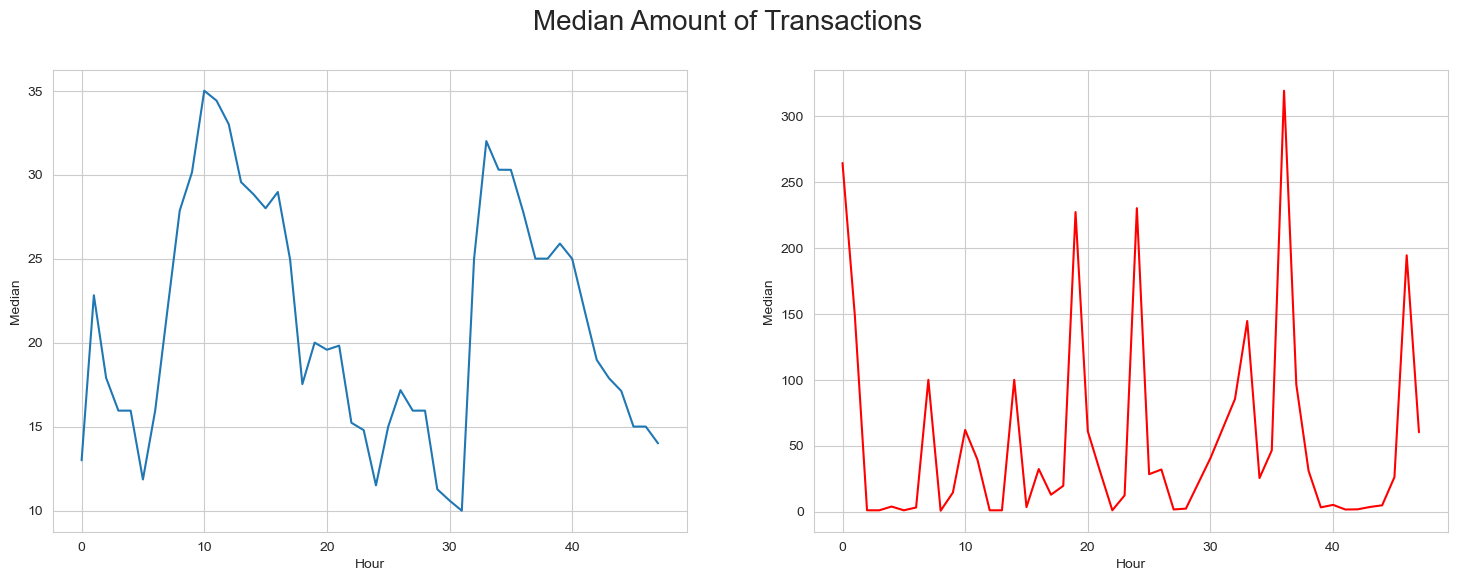

In [83]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions", fontsize=20)
plt.show()

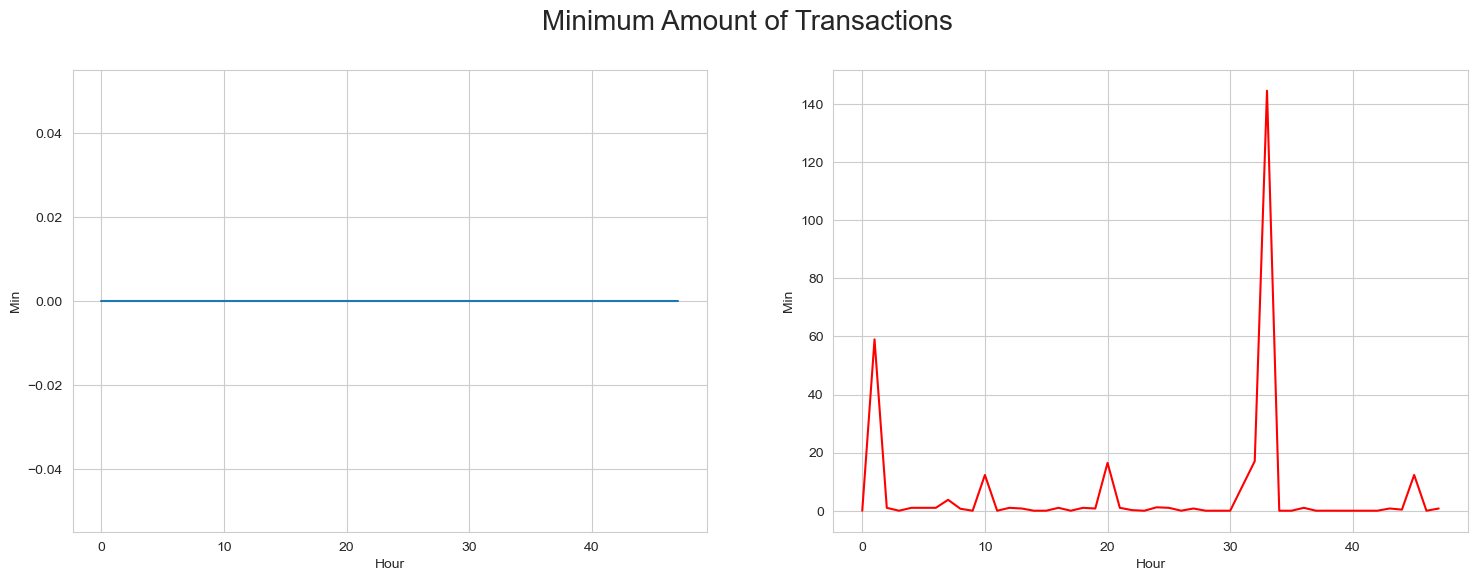

In [84]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions", fontsize=20)
plt.show()

### Transactions Amount

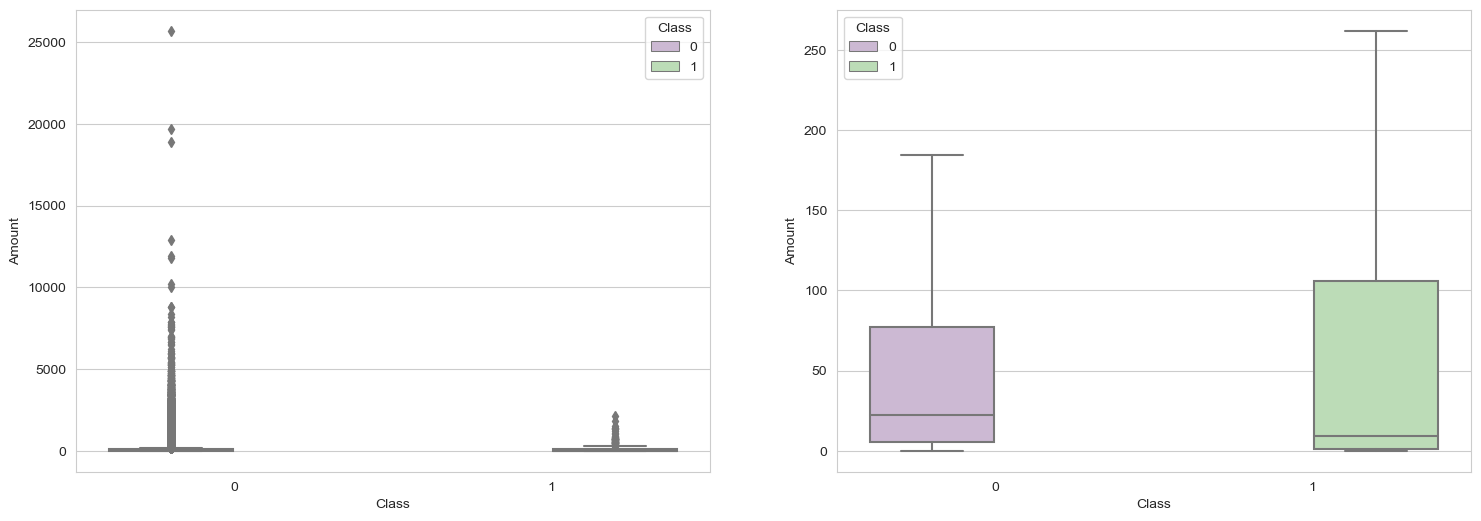

In [85]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class", data=credit_card, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class", data=credit_card, palette="PRGn",showfliers=False)
plt.show()

In [86]:
tmp = credit_card[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class']==0]['Amount']
class_1 = tmp.loc[tmp['Class']==1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [87]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Valid transactions have a higher mean value, larger first quartile (Q1), smaller third and fourth quartiles (Q3 and Q4), and more significant outliers. On the other hand, fraudulent transactions have a smaller Q1 and mean value, larger Q4, and fewer significant outliers.

We will create a graph showing the amount of fraudulent transactions plotted against time, which is measured in seconds from the beginning of the 48-hour time period.

In [88]:
fraud = credit_card.loc[credit_card['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
    marker=dict(
        color='rgb(238,23,11)',
        line=dict(
            color='red',
            width=1),
            opacity=0.5),
    text = fraud['Amount'],
    mode = "markers",
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
                xaxis = dict(title = 'Time [s]', showticklabels=True),
                yaxis = dict(title = 'Amount'),
                hovermode='closest'
)
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

### Features Correlation

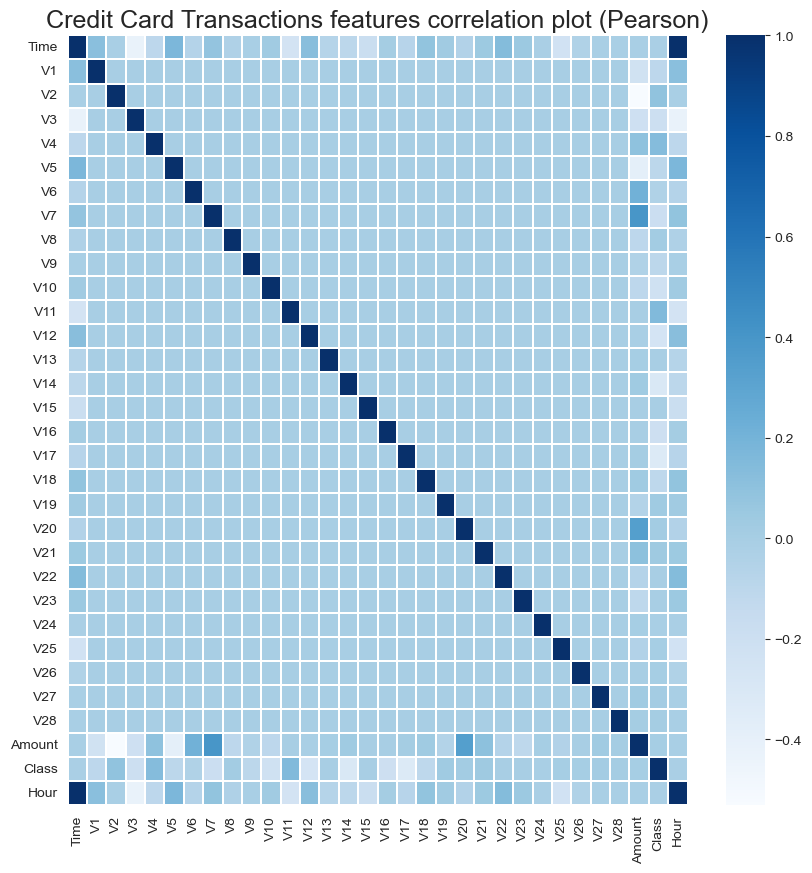

In [89]:
plt.figure(figsize = (10,10))
plt.title('Credit Card Transactions features correlation plot (Pearson)', fontsize=18)
corr = credit_card.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Blues")
plt.show()

As anticipated, there is no significant correlation between the features `V1-V28`. However, some of these features exhibit a correlation with Time `(V3 has an inverse correlation)` and Amount `(V7 and V20 have a direct correlation, while V1 and V5 have an inverse correlation)`.

We will create a graph displaying the directly correlated and inversely correlated values on the same plot. We will begin with the directly correlated values, which are `{V20;Amount}` and `{V7;Amount}`.

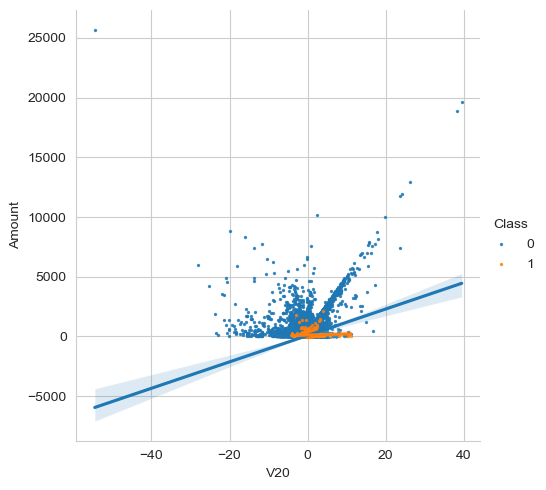

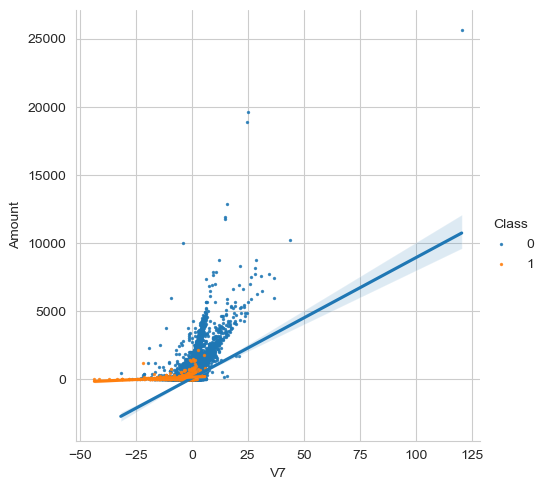

In [90]:
s = sns.lmplot(x='V20', y='Amount',data=credit_card, hue='Class',fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=credit_card, hue='Class',fit_reg=True,scatter_kws={'s':2})
plt.show()

We can verify that the two sets of features are correlated by observing that the regression lines for Class = 0 have a positive slope, while the regression line for Class = 1 has a slightly smaller positive slope.

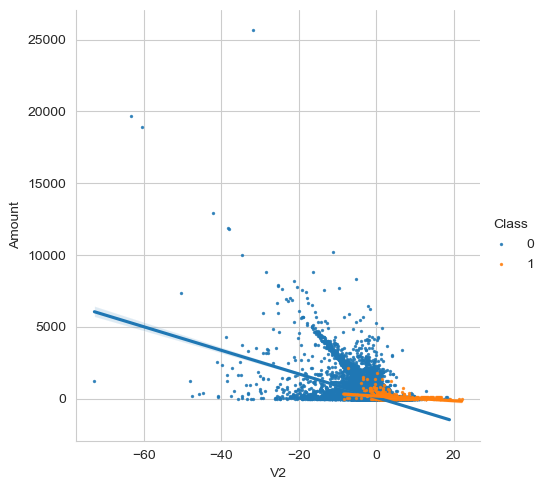

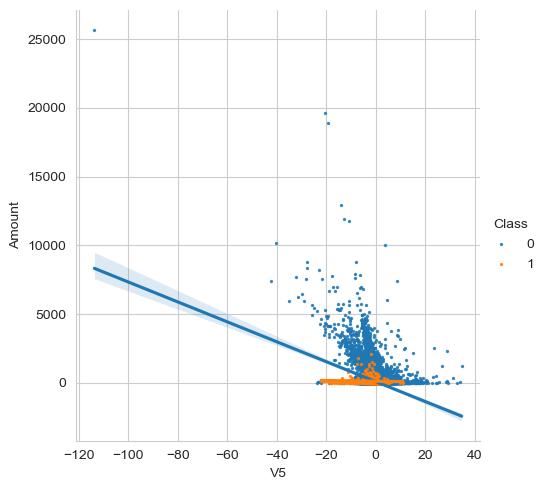

In [91]:
# Plot the inversely correlated values
s = sns.lmplot(x='V2', y='Amount',data=credit_card, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=credit_card, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()


We can verify that the two sets of features are inversely correlated by observing that the regression lines for Class = 0 have a negative slope, while the regression lines for Class = 1 have a very small negative slope.

### Features Density Plot

C:\Users\quang\AppData\Local\Temp\ipykernel_13952\65252744.py:14: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\quang\AppData\Local\Temp\ipykernel_13952\65252744.py:15: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



<Figure size 640x480 with 0 Axes>

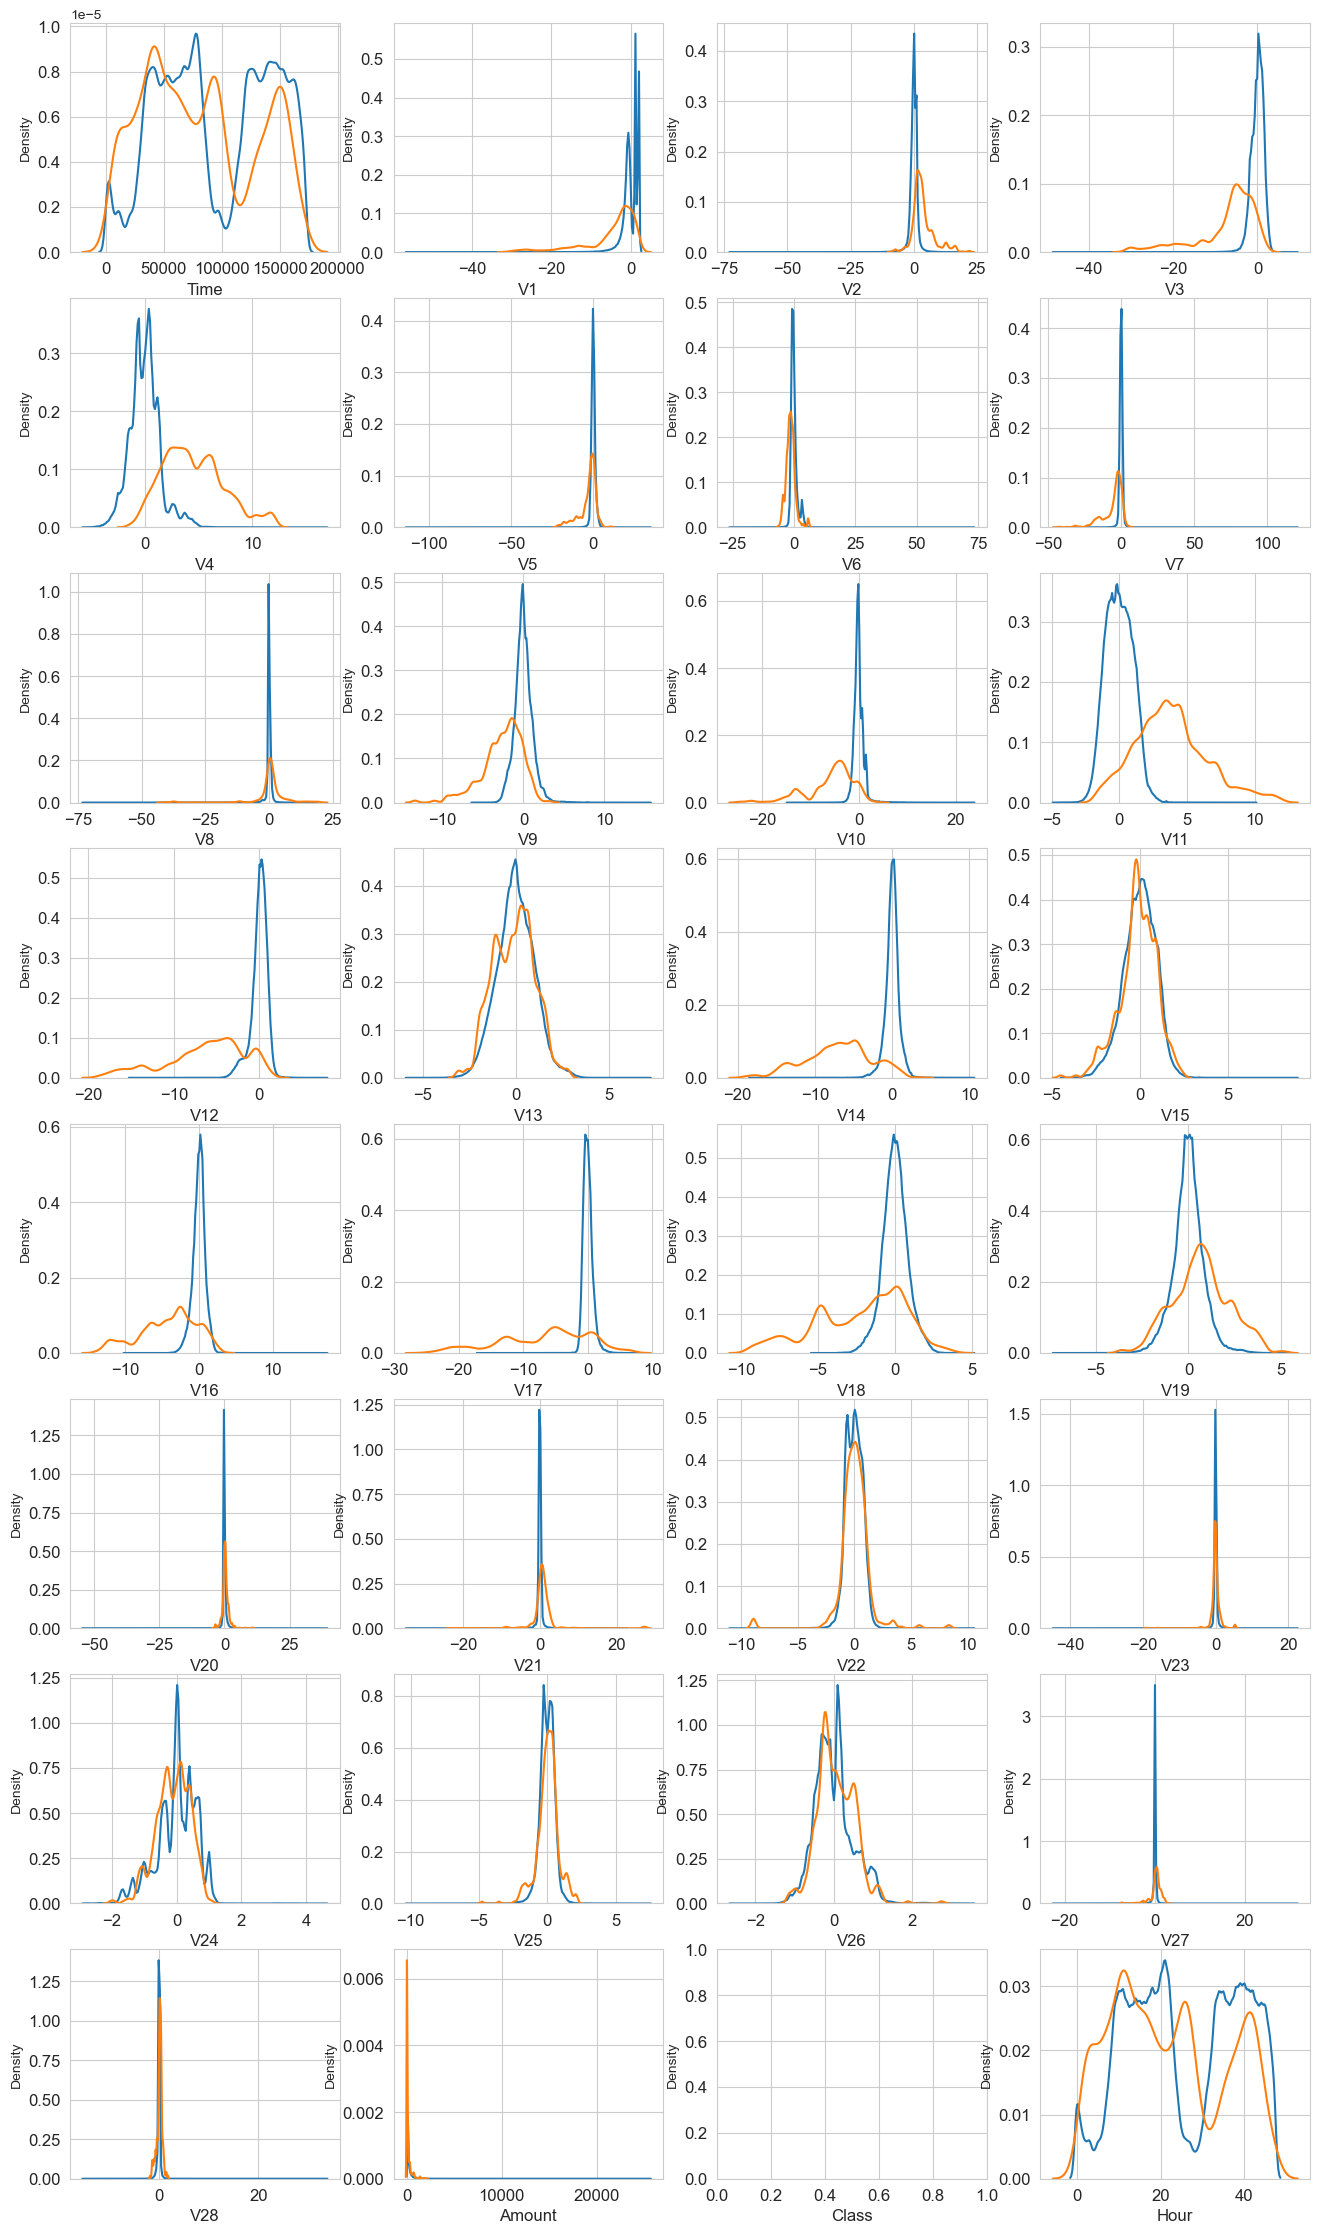

In [92]:
var = credit_card.columns.values

i = 0
t0 = credit_card.loc[credit_card['Class'] == 0]
t1 = credit_card.loc[credit_card['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw_adjust=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw_adjust=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

We can observe good selectivity for certain features in terms of their distribution for the two Class values. Specifically, V4 and V11 have clearly separated distributions for Class values 0 and 1, while V12, V14, and V18 are partially separated. V1, V2, V3, and V10 have a distinct profile, while V25, V26, and V28 have similar profiles for the two Class values.

In general, with few exceptions (Time and Amount), the distribution of features for valid transactions (Class = 0) is centered around 0, sometimes with a long tail at one end. In contrast, fraudulent transactions (Class = 1) have a skewed (asymmetric) distribution.

## Predictive Models

### Define Predictors and target values

In [93]:
target = 'Class'
predictors = ['Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10', \
                'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20', \
                'V21','V22','V23','V24','V25','V26','V27','V28',\
                    'Amount']

### Split data into train, test and validation set

In [94]:
train_df, test_df = train_test_split(credit_card, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle = True)
train_df, valid_df = train_test_split(train_df, test_size = VALID_SIZE, random_state = RANDOM_STATE, shuffle = True)

### RandomForestClassifier

Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation.

We will use as validation criterion GINI, which formula is GINI = 2 * (AUC) - 1, where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC) [4]. Number of estimators is set to 100 and number of parallel jobs is set to 4.

We start by initializing the RandomForestClassifier.

In [95]:
clf = RandomForestClassifier(n_jobs = NO_JOBS,
                             random_state = RANDOM_STATE,
                             criterion = RFC_METRIC,
                             n_estimators = NUM_ESTIMATORS,
                             verbose = False)

In [96]:
# train the RandomFrorestClassifier using the train_df data and fit function
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [97]:
# predict the target values for the valid_df data using predict function
preds = clf.predict(valid_df[predictors])

##### Feature Importances

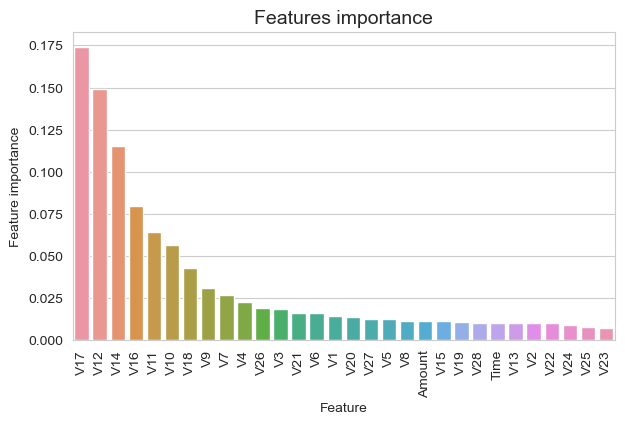

In [98]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance', ascending = False)
plt.figure(figsize = (7,4))
plt.title('Features importance', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

The most important features are `V17, V12, V14, V10, V11, V16`

##### Confusion Matrix

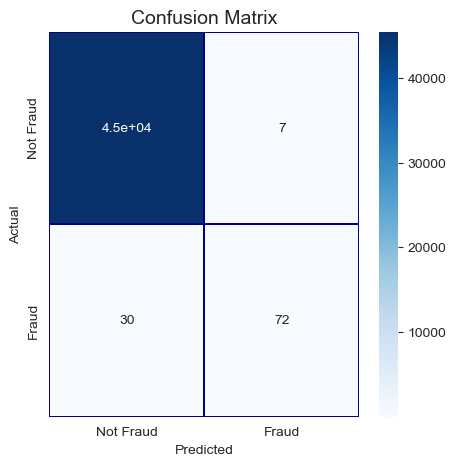

In [99]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], annot = True, ax=ax1, linewidths = 0.2, linecolor='Darkblue', cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

##### Type I error and Type II error
We need to clarify that confussion matrix are not a very good tool to represent the results in the case of largely unbalanced data, because we will actually need a different metrics that accounts in the same time for the `selectivity` and `specificity` of the method we are using, so that we minimize in the same time both `Type I errors` and `Type II errors`.

`Null Hypothesis (H0)` - The transaction is not a fraud.
`Alternative Hypothesis (H1)` - The transaction is a fraud.

`Type I error` - You reject the null hypothesis when the null hypothesis is actually true.
`Type II error` - You fail to reject the null hypothesis when the the alternative hypothesis is true.

`Cost of Type I error` - You erroneously presume that the the transaction is a fraud, and a true transaction is rejected.

`Cost of Type II error` - You erroneously presume that the transaction is not a fraud and a ffraudulent transaction is accepted.

##### Area Under Curve (AUC)

In [100]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

The `ROC-AUC` score obtained with `RandomForestClassifier` is `0.852`

### AdaBoostClassifier

AdaBoostClassifier stand for Adaptive Boosting Classifier

In [101]:
# Prepare the model
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=NUM_ESTIMATORS)

In [102]:
# fit the model
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [103]:
# predict the target values
preds = clf.predict(valid_df[predictors])

##### Features Importances

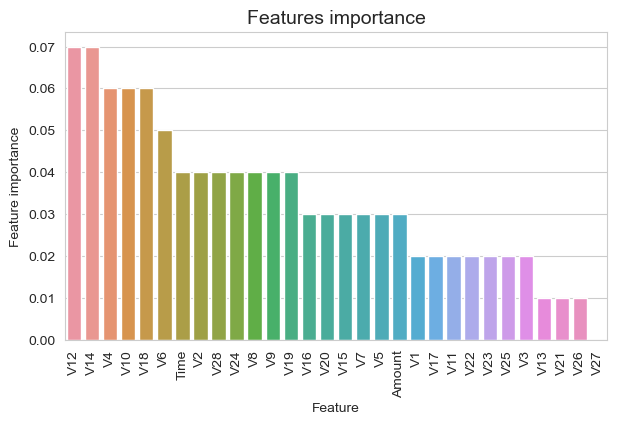

In [104]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

##### Confusion Matrix

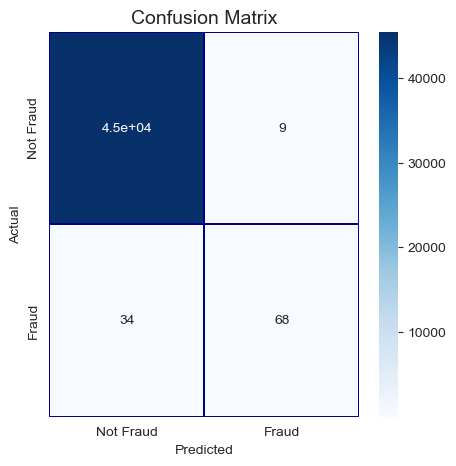

In [105]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], annot = True, ax=ax1, linewidths = 0.2, linecolor='Darkblue', cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

##### Area under Curve

In [106]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

The ROC-AUC score obtained with AdaBoostClassifier is 0.856

### CatBoostClassifier

CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data

In [107]:
# prepare the model
clf = CatBoostClassifier(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='AUC',
                         random_seed = RANDOM_STATE,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = VERBOSE_EVAL,
                         od_wait=100)

In [108]:
# fit the model
clf.fit(train_df[predictors], train_df[target].values, verbose=True)

0:	total: 631ms	remaining: 5m 14s
50:	total: 31.4s	remaining: 4m 36s
100:	total: 1m	remaining: 3m 59s
150:	total: 1m 29s	remaining: 3m 26s
200:	total: 1m 58s	remaining: 2m 55s
250:	total: 2m 26s	remaining: 2m 25s
300:	total: 2m 54s	remaining: 1m 55s
350:	total: 3m 23s	remaining: 1m 26s
400:	total: 3m 52s	remaining: 57.4s
450:	total: 4m 25s	remaining: 28.8s
499:	total: 4m 53s	remaining: 0us


In [109]:
# Predict the target values
preds = clf.predict(valid_df[predictors])

##### Feature importance

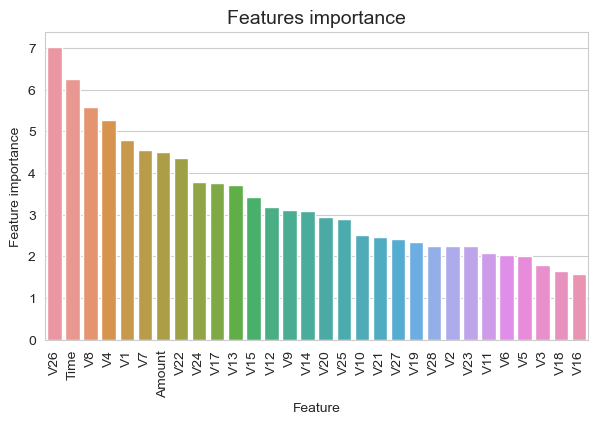

In [110]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

##### Confusion Matrix

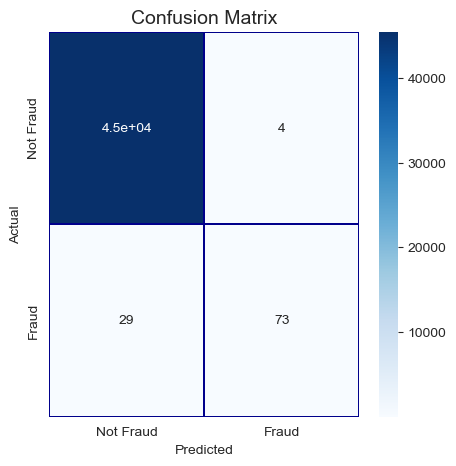

In [111]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

##### Area under Curve

In [112]:
roc_auc_score(valid_df[target].values, preds)

0.8577991493075996

The ROC-AUC score obtained with CatBoostClassifier is 0.887

### XGBoostClassifier

XGBoost is a gradient boosting algorithm

In [113]:
# Prepare the train and valid datasets

dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)



In [114]:
# What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [115]:
# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 5
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [116]:
# train the model
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

c:\Anaconda\envs\pandas_playground\Lib\site-packages\xgboost\core.py:617: FutureWarning:

Pass `evals` as keyword args.



[20:24:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.93440	valid-auc:0.87723
[50]	train-auc:0.94458	valid-auc:0.88182
[58]	train-auc:0.94628	valid-auc:0.88177


##### Plot variable importance

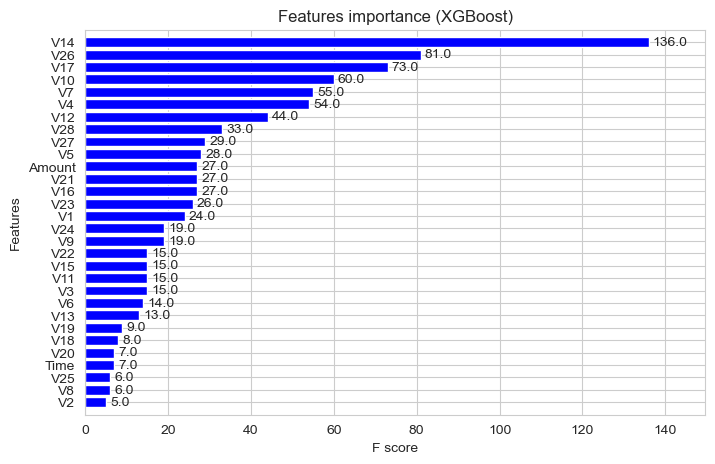

In [117]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="blue")
plt.show()

In [118]:
# Predict test set
preds = model.predict(dtest)

##### Area under Curve

In [119]:
roc_auc_score(test_df[target].values, preds)

0.9245613063205657

The AUC score of the prediction of test set is ~ 0.98

### LightGBM


In [120]:
# Define model parameters
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [121]:
# Prepare the model
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [122]:
# Run the model
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

c:\Anaconda\envs\pandas_playground\Lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

c:\Anaconda\envs\pandas_playground\Lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

c:\Anaconda\envs\pandas_playground\Lib\site-packages\lightgbm\engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025123 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.997909	valid's auc: 0.952288
[100]	train's auc: 0.999032	valid's auc: 0.945553
Early stopping, best iteration is:
[29]	train's auc: 0.996594	valid's auc: 0.957864


Best validation score was obtained for round 85, for which AUC ~= 0.957

##### Importance Variable

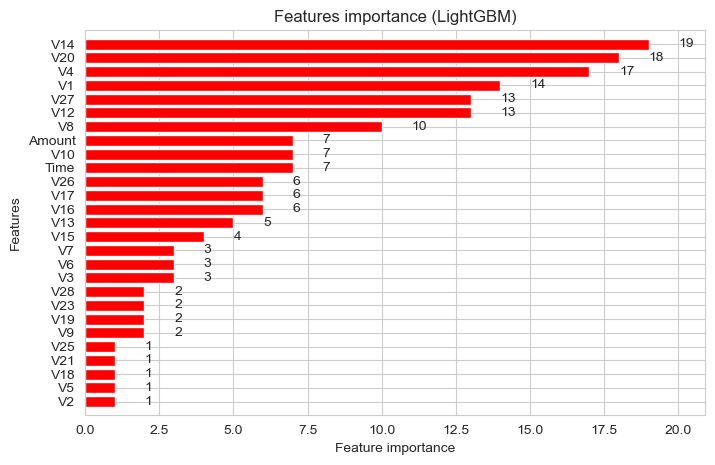

In [123]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [124]:
# Predict the test data
preds = model.predict(test_df[predictors])

##### Area under Curve

In [125]:
roc_auc_score(test_df[target].values, preds)

0.9473337202349548

The ROC-AUC score obtained for the test set is 0.947.

### Training and validation using cross-validation

Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

Test set is calculated as an average of the predictions

In [126]:
kf = KFold(n_splits=NUMBER_KFOLDS, random_state=RANDOM_STATE, shuffle=True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx], train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx], train_df[target].iloc[valid_idx]

    evals_results = {}
    model = LGBMClassifier(
        nthread=-1,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=80,
        colsample_bytree=0.98,
        subsample=0.78,
        reg_alpha=0.04,
        reg_lambda=0.073,
        subsample_for_bin=50,
        boosting_type='gbdt',
        is_unbalance=False,
        min_split_gain=0.025,
        min_child_weight=40,
        min_child_samples=510,
        objective='binary',
        metric='auc',
        verbose=-1,  # Use verbose=-1 instead of silent
        feval=None
    )

    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
              eval_metric='auc', early_stopping_rounds=10)  # Pass callbacks argument instead of early_stopping_rounds

    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

c:\Anaconda\envs\pandas_playground\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[1]	training's auc: 0.879369	valid_1's auc: 0.885844
[2]	training's auc: 0.879369	valid_1's auc: 0.885844
[3]	training's auc: 0.952509	valid_1's auc: 0.970207
[4]	training's auc: 0.952509	valid_1's auc: 0.970207
[5]	training's auc: 0.952673	valid_1's auc: 0.970207
[6]	training's auc: 0.952509	valid_1's auc: 0.970207
[7]	training's auc: 0.957844	valid_1's auc: 0.974463
[8]	training's auc: 0.958169	valid_1's auc: 0.97472
[9]	training's auc: 0.95828	valid_1's auc: 0.97472
[10]	training's auc: 0.9582	valid_1's auc: 0.97472
[11]	training's auc: 0.9582	valid_1's auc: 0.97472
[12]	training's auc: 0.9582	valid_1's auc: 0.97472
[13]	training's auc: 0.96089	valid_1's auc: 0.977139
[14]	training's auc: 0.96243	valid_1's auc: 0.978344
[15]	training's auc: 0.96243	valid_1's auc: 0.978344
[16]	training's auc: 0.962271	valid_1's auc: 0.978495
[17]	training's auc: 0.962271	valid_1's auc: 0

c:\Anaconda\envs\pandas_playground\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[1]	training's auc: 0.883072	valid_1's auc: 0.850214
[2]	training's auc: 0.959065	valid_1's auc: 0.927305
[3]	training's auc: 0.956317	valid_1's auc: 0.932198
[4]	training's auc: 0.972157	valid_1's auc: 0.946047
[5]	training's auc: 0.974896	valid_1's auc: 0.952236
[6]	training's auc: 0.975819	valid_1's auc: 0.954135
[7]	training's auc: 0.972336	valid_1's auc: 0.94921
[8]	training's auc: 0.974821	valid_1's auc: 0.953665
[9]	training's auc: 0.976061	valid_1's auc: 0.95647
[10]	training's auc: 0.972153	valid_1's auc: 0.949444
[11]	training's auc: 0.974875	valid_1's auc: 0.953799
[12]	training's auc: 0.975901	valid_1's auc: 0.956535
[13]	training's auc: 0.975025	valid_1's auc: 0.951296
[14]	training's auc: 0.975118	valid_1's auc: 0.951555
[15]	training's auc: 0.975171	valid_1's auc: 0.951645
[16]	training's auc: 0.975326	valid_1's auc: 0.951746
[17]	training's auc: 0.975129	val

c:\Anaconda\envs\pandas_playground\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[1]	training's auc: 0.895704	valid_1's auc: 0.845523
[2]	training's auc: 0.895704	valid_1's auc: 0.845523
[3]	training's auc: 0.962538	valid_1's auc: 0.904114
[4]	training's auc: 0.962538	valid_1's auc: 0.904114
[5]	training's auc: 0.962538	valid_1's auc: 0.904114
[6]	training's auc: 0.962538	valid_1's auc: 0.904114
[7]	training's auc: 0.962538	valid_1's auc: 0.904114
[8]	training's auc: 0.969974	valid_1's auc: 0.911462
[9]	training's auc: 0.969974	valid_1's auc: 0.911462
[10]	training's auc: 0.969974	valid_1's auc: 0.911462
[11]	training's auc: 0.967911	valid_1's auc: 0.911758
[12]	training's auc: 0.967911	valid_1's auc: 0.911758
[13]	training's auc: 0.971156	valid_1's auc: 0.913244
[14]	training's auc: 0.972406	valid_1's auc: 0.917633
[15]	training's auc: 0.972477	valid_1's auc: 0.917016
[16]	training's auc: 0.975536	valid_1's auc: 0.917733
[17]	training's auc: 0.975536	v

c:\Anaconda\envs\pandas_playground\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[1]	training's auc: 0.883167	valid_1's auc: 0.881923
[2]	training's auc: 0.948112	valid_1's auc: 0.954993
[3]	training's auc: 0.9515	valid_1's auc: 0.953092
[4]	training's auc: 0.966402	valid_1's auc: 0.970639
[5]	training's auc: 0.960645	valid_1's auc: 0.968182
[6]	training's auc: 0.963048	valid_1's auc: 0.96866
[7]	training's auc: 0.966707	valid_1's auc: 0.97105
[8]	training's auc: 0.967691	valid_1's auc: 0.979185
[9]	training's auc: 0.967128	valid_1's auc: 0.983169
[10]	training's auc: 0.96403	valid_1's auc: 0.982655
[11]	training's auc: 0.964368	valid_1's auc: 0.981105
[12]	training's auc: 0.967451	valid_1's auc: 0.98315
[13]	training's auc: 0.968375	valid_1's auc: 0.983127
[14]	training's auc: 0.965356	valid_1's auc: 0.983003
[15]	training's auc: 0.964989	valid_1's auc: 0.985166
[16]	training's auc: 0.964554	valid_1's auc: 0.988926
[17]	training's auc: 0.969351	valid_1

c:\Anaconda\envs\pandas_playground\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[1]	training's auc: 0.876684	valid_1's auc: 0.880911
[2]	training's auc: 0.876684	valid_1's auc: 0.880911
[3]	training's auc: 0.882723	valid_1's auc: 0.887746
[4]	training's auc: 0.882723	valid_1's auc: 0.887746
[5]	training's auc: 0.882723	valid_1's auc: 0.887746
[6]	training's auc: 0.935942	valid_1's auc: 0.945119
[7]	training's auc: 0.942866	valid_1's auc: 0.951208
[8]	training's auc: 0.943425	valid_1's auc: 0.951539
[9]	training's auc: 0.943468	valid_1's auc: 0.951352
[10]	training's auc: 0.952096	valid_1's auc: 0.958044
[11]	training's auc: 0.952522	valid_1's auc: 0.958433
[12]	training's auc: 0.952522	valid_1's auc: 0.958433
[13]	training's auc: 0.952522	valid_1's auc: 0.958433
[14]	training's auc: 0.956199	valid_1's auc: 0.961157
[15]	training's auc: 0.955941	valid_1's auc: 0.961185
[16]	training's auc: 0.964449	valid_1's auc: 0.971552
[17]	training's auc: 0.964367	v

The AUC score for the prediction from the test data was 0.949.

We prepare the test prediction, from the averaged predictions for test over the 5 folds.

In [127]:
pred = test_preds